the dataset used in this note book can be foud at:  
https://www.kaggle.com/datasets/plhalvorsen/kvasir-v2-a-gastrointestinal-tract-dataset  
https://www.tensorflow.org/tutorials/load_data/images

Importing libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib
from tqdm import tqdm
from keras.models import Model
from google.colab.patches import cv2_imshow

Copiying the dataset from Gdrive to session

In [7]:
!cp -r '/content/drive/MyDrive/Kaggle/Polypes Dataset' /content/

In [8]:
path = '/content/Polypes Dataset'

In [9]:
data_dir = tf.keras.utils.image_dataset_from_directory(path)
data_dir = pathlib.Path(path)
print(data_dir)
print(os.path.abspath(data_dir))

Found 8000 files belonging to 8 classes.
/content/Polypes Dataset
/content/Polypes Dataset


In [10]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

8000


In [11]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(8000, reshuffle_each_iteration=False)

In [12]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/Polypes Dataset/dyed-lifted-polyps/98ecb81e-5a43-4a3b-96fd-03a02b715764.jpg'
b'/content/Polypes Dataset/esophagitis/19ff477f-f024-4cef-9e2c-e61ad3a47002.jpg'
b'/content/Polypes Dataset/ulcerative-colitis/584f1fa0-9bb9-49d3-b412-c42819d0a200_00003006.jpg'
b'/content/Polypes Dataset/dyed-lifted-polyps/0d53b1bb-ed38-4458-8e88-729d5fe4939e.jpg'
b'/content/Polypes Dataset/normal-pylorus/e6e288b6-22b9-4592-8f00-28dba8df2212.jpg'


In [13]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
class_names

array(['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis',
       'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps',
       'ulcerative-colitis'], dtype='<U22')

In [14]:
val_size = int(image_count * 0.2)
# Total_DS = list_ds.skip(val_size)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [15]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

6400
1600


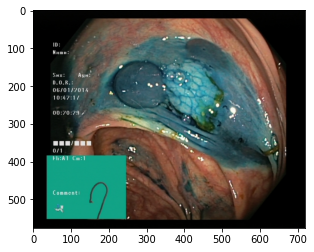

In [16]:
img = cv.imread('/content/Polypes Dataset/dyed-lifted-polyps/007d5aa7-7289-4bad-aa4a-5c3a259e9b19.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

In [17]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [18]:
batch_size = 128
img_height = 200
img_width = 200

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [21]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

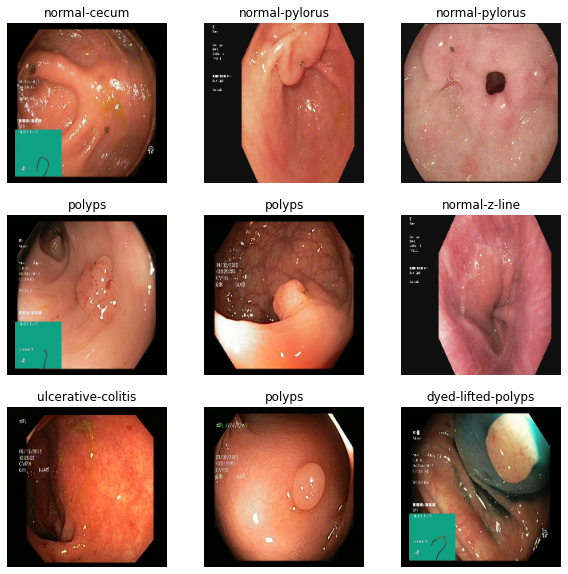

In [22]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [23]:
num_classes = len(class_names)

In [24]:
EnteryLayer = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Resizing(img_height, img_width),
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomContrast(factor=0.2),
    layers.RandomRotation(0.5, fill_mode='reflect'),
    # layers.RandomTranslation(0.1, 0.1),
    # layers.GaussianNoise(0.3),
  ])

In [25]:
model1 = Sequential([
  EnteryLayer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

In [26]:
model1.compile(optimizer= 'Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)       

In [114]:
epochs=50
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/50
50/50 [==============================] - 9s 135ms/step - loss: 1.8059 - accuracy: 0.2761 - val_loss: 1.2031 - val_accuracy: 0.4856
Epoch 2/50
50/50 [==============================] - 7s 133ms/step - loss: 1.3113 - accuracy: 0.4270 - val_loss: 0.9362 - val_accuracy: 0.5625
Epoch 3/50
50/50 [==============================] - 6s 129ms/step - loss: 1.0923 - accuracy: 0.4973 - val_loss: 0.8445 - val_accuracy: 0.5813
Epoch 4/50
50/50 [==============================] - 6s 128ms/step - loss: 0.9883 - accuracy: 0.5370 - val_loss: 0.7810 - val_accuracy: 0.6237
Epoch 5/50
50/50 [==============================] - 7s 129ms/step - loss: 0.9137 - accuracy: 0.5688 - val_loss: 0.7404 - val_accuracy: 0.6300
Epoch 6/50
50/50 [==============================] - 6s 128ms/step - loss: 0.8508 - accuracy: 0.5836 - val_loss: 0.7130 - val_accuracy: 0.6544
Epoch 7/50
50/50 [==============================] - 6s 128ms/step - loss: 0.8313 - accuracy: 0.5958 - val_loss: 0.6496 - val_accuracy: 0.6744
Epoch 

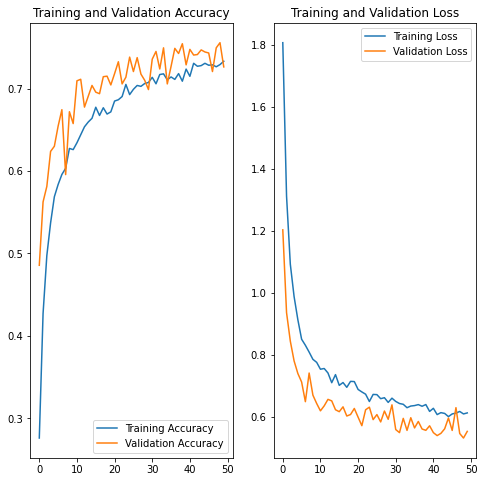

In [115]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
from tensorflow.keras.applications import VGG19

In [29]:
VGG19Model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=num_classes,
    )

80150528/80134624 [==============================] - 0s 0us/step


In [36]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  VGG19Model,
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_11 (Dense)            (None, 256)               1179904   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [40]:
# epochs=50
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs,
# )

In [41]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [42]:
layer_names = [layer.name for layer in model1.layers]
layer_names.pop(0)
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'flatten',
 'dense',
 'dropout',
 'dense_1',
 'dropout_1',
 'dense_2']

In [43]:
layer_outputs = [layer.output for layer in model1.layers]
layer_outputs.pop(0)
layer_outputs

[<KerasTensor: shape=(None, 200, 200, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 100, 100, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 100, 100, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 50, 50, 32) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 50, 50, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 25, 25, 64) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 40000) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dropout_1')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'dense_2

In [44]:
feature_map_model = tf.keras.models.Model(model1.input, layer_outputs)

In [45]:
input = cv.imread('/content/Polypes Dataset/dyed-lifted-polyps/0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg')